---
---

# Spaceship Titanic (kaggle competition)

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<div style='text-align: center;'>
    <img src='../imgs/spaceshipTitanic.jpg' alt='Spaceship Titanic' width='50%'/>
</div>

---
## Feature Information:

|Variable|Description|
|-|-|
|`PassengerId`|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always|
|`HomePlanet`|The planet the passenger departed from, typically their planet of permanent residence|
|`CryoSleep`|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins|
|`Cabin`|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard|
|`Destination`|The planet the passenger will be debarking to|
|`Age`|The age of the passenger|
|`VIP`|Whether the passenger has paid for special VIP service during the voyage|
|`RoomService`|Amount the passenger has billed for room service|
|`FoodCourt`|Amount the passenger has billed at the food court|
|`ShoppingMall`|Amount the passenger has billed at the shopping mall|
|`Spa`|Amount the passenger has blled at the spa|
|`VR Deck`|Amount the passenger has billed at the VR deck|
|`Name`|The first and last name of the passenger|
|`Transported`|Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict|
  
## Submission Info:

A submission file in the correct format:
 - `PassengerId`: Id for each passenger in the test set.
 - `Transported`: The target. For each passenger, predict either True or False.

## Metric Info:

Submissions are evaluated based on their classification accuracy, the percentage of predicted labels that are correct.

---
---
## Introduction

This notebook aims to:
1. Carry out a full EDA of the Spaceship Titanic train dataset
    - Univariate
    - Bivariate
    - Multivariate
2. Include relevant feature engineering
3. Develop machine learning models (with sklearn)
    - Classification algorithms
    - Try using VotingClassifier and StackingClassifier
4. Produce a valid submission for the kaggle competition

---
---
## Imports

In [1]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer, FunctionTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztoolz as viz
import mltoolz as mlt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

---
## Load Datasets

Separate train and test datasets provided

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

print('-'*16)
print(f'Train Set Shape:\n{train.shape}')
print('-'*16)
print(f'Test Set Shape:\n{test.shape}')
print('-'*16)

----------------
Train Set Shape:
(8693, 14)
----------------
Test Set Shape:
(4277, 13)
----------------


---
## Train Dataset Info Review:

In [3]:
mlt.describe_and_suggest(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns)
dtypes: object(7), float64(6), bool(1)
memory usage: 3461.6 KB

Total Percentage of Null Values: 26.73%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
PassengerId,object,8693,0,0.00,8693,100.00,Categorical
HomePlanet,object,8492,201,2.31,3,0.03,Categorical
CryoSleep,object,8476,217,2.50,2,0.02,Binary
Cabin,object,8494,199,2.29,6560,75.46,Categorical
Destination,object,8511,182,2.09,3,0.03,Categorical
Age,float64,8514,179,2.06,80,0.92,Numerical Discrete
VIP,object,8490,203,2.34,2,0.02,Binary
RoomService,float64,8512,181,2.08,1273,14.64,Numerical Continuous
FoodCourt,float64,8510,183,2.11,1507,17.34,Numerical Continuous
ShoppingMall,float64,8485,208,2.39,1115,12.83,Numerical Continuous


In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


---
## Split train into train and validation

- This will require filling NaNs first then i will turn them back into NaNs to implement a cleaning and imputation strategy
- I have chosen to split the training data into a train and validation set to avoid data leakage and preserve a sample for validating models before moving on to testing with the test / prediction set and submitting to Kaggle.
    - As there are over 8000 samples in the training dataset i do not think the reduction creating by splitting will drastically reduce the performance of any models, however, it might be worth considering a trial of training on the entire dataset as well.
    - For now i will continue with a split dataset into train and validation

In [5]:
# Change NaNs to 'unk'
train.fillna('unk', axis=1, inplace=True)

In [6]:
# Split train into train and val sets
train_set, val_set = train_test_split(train, test_size=0.25, stratify=train['Transported'], random_state=42)

In [7]:
# Turn 'unk' back into NaNs 
for dset in [train_set, val_set]:
    dset.replace('unk', np.nan, inplace=True)

---
## Define Target

As I know that the objective is to predict `Transported` i will define the target here

In [8]:
target = 'Transported'

---
---
## Imputation Strategy for NaN values

This is perhaps an overly complicated strategy for imputing NaN values. However, i want to use this project as an exercise to try out different ideas and methods that i have been learning and reading about.

- All columns except `PassengerId` and `Transported` have around 2% NaN values
- A full dropna() call is out of the question given that the total percentage of missing values is nearly 27%
- Need to devise a strategy to impute missing values in the test set that does not prejudice and predictions

I initially wanted to try a strategy that combines ordinal coding with KNN imputation, however there seem to be drawbacks and methodological flaws in this method. Namely, that assigining arbitrary oridnal values to categorical variables potentially implies relationships with other data that simply do not exist and therefore seems fundmentally incorrect.

### Idea for workflow:

***NOTE***: these ideas were discovered through EDA

- Use `PassengerId` to extract whether a passenger travelled in a group or not
- Assuming that people within the same group likely left/are from the same planet
    1. Impute `HomePlanet` NaNs based on travel groups
    2. `VIP` has very high percentage of people with `HomePlanet as 'Europa' so anyone with `VIP` = True, impute `HomePlanet` as 'Europa'
    3. Any remaining NaNs filled with modeal `HomePlanet`
- Bivariate analysis of Categorical columns with viz.categorical_relationships() to visualize relationship and calculate mutual_info_score.
- Impute proportionally based on categorical column with highest mutual info score (`HomePlanet` seemed to be strongest indicator for all other categorical columns)
- Use a function to carry out imputations
- Impute numerical columns NaN values using KNNImputer(n_neighbors=5)

In [9]:
mlt.describe_and_suggest(train_set)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519 entries, 0 to 6518
Data columns (total 14 columns)
dtypes: object(7), float64(6), bool(1)
memory usage: 2646.3 KB

Total Percentage of Null Values: 26.81%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
PassengerId,object,6519,0,0.00,6519,100.00,Categorical
HomePlanet,object,6362,157,2.41,3,0.05,Categorical
CryoSleep,object,6358,161,2.47,2,0.03,Binary
Cabin,object,6371,148,2.27,5150,79.00,Categorical
Destination,object,6372,147,2.25,3,0.05,Categorical
Age,float64,6390,129,1.98,80,1.23,Numerical Discrete
VIP,object,6370,149,2.29,2,0.03,Binary
RoomService,float64,6385,134,2.06,1055,16.18,Numerical Continuous
FoodCourt,float64,6373,146,2.24,1241,19.04,Numerical Continuous
ShoppingMall,float64,6371,148,2.27,953,14.62,Numerical Continuous


In [10]:
# Transform 'PassengerId' into some more useful variables
train_set['GroupId'] = train_set['PassengerId'].str.split('_').str[0]
train_set['PassengerNumber'] = train_set['PassengerId'].str.split('_').str[1].astype(float)

group_counts = train_set['GroupId'].value_counts()
train_set['GroupSize'] = train_set['GroupId'].map(group_counts)
train_set['InGroup'] = np.where(train_set['GroupSize'] > 1, 1, 0)

# Transform 'Cabin' into potentially more useful variables
train_set['Deck'] = train_set['Cabin'].str.split('/').str[0]
train_set['CabinNumber'] = train_set['Cabin'].str.split('/').str[1].astype(float)
train_set['Side'] = train_set['Cabin'].str.split('/').str[2]

bin_edges = np.linspace(train_set['CabinNumber'].min(), train_set['CabinNumber'].max(), 5)
train_set['CabinPosition'] = pd.cut(train_set['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)


# Fill NaNs im 'HomePlanet'
mode_by_group = train_set.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
train_set.loc[train_set['HomePlanet'].isna(), 'HomePlanet'] = mode_by_group[train_set['HomePlanet'].isna()]

mode_by_deck = train_set.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
train_set.loc[train_set['HomePlanet'].isna(), 'HomePlanet'] = mode_by_deck[train_set['HomePlanet'].isna()]

train_set.loc[train_set['VIP'] & train_set['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'

train_set['HomePlanet'].fillna(train_set.HomePlanet.mode()[0], inplace=True)

# Fill NaNs in other remaining categorical columns

# 1. Create function to fill based on proportionality of columns
# used viz.categorical relationships to decide which columns proportions had highest mutual info with given column
# Made function to proportionally impute NaNs
def proportional_imputer(df, groupby_col='', impute_col=''):
    proportions = df.groupby(groupby_col)[impute_col].value_counts(normalize=True)

    def impute_values(row):
        if pd.isna(row[impute_col]):
            group = row[groupby_col]
            if pd.notna(group) and group in proportions.index:
                group_proportions = proportions.loc[group].dropna()
                return np.random.choice(group_proportions.index, p=group_proportions.values)
        return row[impute_col]
    
    df[impute_col] = df.apply(impute_values, axis=1)
    return df

# For loop to cycle through remaining categorical columns
for col in ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']:
    train_set = proportional_imputer(train_set, groupby_col='HomePlanet', impute_col=col)

# Impute NaNs in numerical columns using KNN imputer (n_neighbors=5)
knnimputer_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
knn_imputer = KNNImputer(n_neighbors=5)
train_set[knnimputer_cols] = knn_imputer.fit_transform(train_set[knnimputer_cols])

# Create 'TotalSpent' column
train_set['TotalSpent'] = train_set[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Drop unnecessary columns. Not really necessary as going to reorder columns
droppers = ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name']
train_set.drop(droppers, axis=1, inplace=True)

"""# Reorder dataframe for my own idosyncracies
ordered = ['HomePlanet','Destination','Deck','CabinPosition','Side','VIP','CryoSleep','InGroup','GroupSize','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent','Transported']
train_set = train_set[ordered]"""

# Recast binary features as integers
for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
    if col in train_set.columns:
        train_set[col] = train_set[col].astype(int)

In [11]:
train_set.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,InGroup,Deck,Side,CabinPosition,TotalSpent
2074,Earth,0,TRAPPIST-1e,28.8,0,0.0,86.0,0.0,252.0,570.0,0,1,0,G,S,Front,908.0
6448,Mars,0,TRAPPIST-1e,30.0,0,768.0,11.0,2010.0,0.0,0.0,1,4,1,E,S,Front,2789.0
8117,Earth,0,TRAPPIST-1e,8.0,0,0.0,0.0,0.0,0.0,0.0,0,3,1,G,S,Third,0.0
5397,Earth,0,TRAPPIST-1e,24.0,0,23.0,0.0,0.0,838.0,193.0,0,2,1,F,S,Third,1054.0
6867,Europa,1,TRAPPIST-1e,25.0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,C,S,Front,0.0


---
## Check for complete imputation of NaNs and correct data types

In [12]:
info_df = mlt.describe_and_suggest(train_set)
info_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519 entries, 0 to 6518
Data columns (total 17 columns)
dtypes: float64(7), object(5), int64(5)
memory usage: 2370.4 KB

Total Percentage of Null Values: 0.00%


,Data Type,Not-Null,Missing,Missing (%),Unique,Cardinality (%),Suggested Type
HomePlanet,object,6519,0,0.0,3,0.05,Categorical
CryoSleep,int64,6519,0,0.0,2,0.03,Binary
Destination,object,6519,0,0.0,3,0.05,Categorical
Age,float64,6519,0,0.0,127,1.95,Numerical Discrete
VIP,int64,6519,0,0.0,2,0.03,Binary
RoomService,float64,6519,0,0.0,1108,17.00,Numerical Continuous
FoodCourt,float64,6519,0,0.0,1301,19.96,Numerical Continuous
ShoppingMall,float64,6519,0,0.0,1009,15.48,Numerical Continuous
Spa,float64,6519,0,0.0,1156,17.73,Numerical Continuous
VRDeck,float64,6519,0,0.0,1127,17.29,Numerical Continuous


---
## Apply all transformations and imputations to validation set

- If there are no issues then i will try to build this into a pipeline. 
- Unnecessary for this problem/project, but good practice.
- Pipelines possibly won't save much code as majority over processing has been done through functions which will have to be put into FunctionTransformers. However, it ensures unbiased assessment of validation fold in cross-validation. All steps will be executed in order for each fold.

In [13]:
# Transform 'PassengerId' into some more useful variables
val_set['GroupId'] = val_set['PassengerId'].str.split('_').str[0]
val_set['PassengerNumber'] = val_set['PassengerId'].str.split('_').str[1].astype(float)

group_counts = val_set['GroupId'].value_counts()
val_set['GroupSize'] = val_set['GroupId'].map(group_counts)
val_set['InGroup'] = np.where(val_set['GroupSize'] > 1, 1, 0)

# Transform 'Cabin' into potentially more useful variables
val_set['Deck'] = val_set['Cabin'].str.split('/').str[0]
val_set['CabinNumber'] = val_set['Cabin'].str.split('/').str[1].astype(float)
val_set['Side'] = val_set['Cabin'].str.split('/').str[2]

bin_edges = np.linspace(val_set['CabinNumber'].min(), val_set['CabinNumber'].max(), 5)
val_set['CabinPosition'] = pd.cut(val_set['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)

# Fill NaNs im 'HomePlanet'
mode_by_group = val_set.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
val_set.loc[val_set['HomePlanet'].isna(), 'HomePlanet'] = mode_by_group[val_set['HomePlanet'].isna()]

mode_by_deck = val_set.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
val_set.loc[val_set['HomePlanet'].isna(), 'HomePlanet'] = mode_by_deck[val_set['HomePlanet'].isna()]

val_set.loc[val_set['VIP'] & val_set['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'

val_set['HomePlanet'].fillna(val_set.HomePlanet.mode()[0], inplace=True)

# Fill NaNs in other remaining categorical columns

# 1. Create function to fill based on proportionality of columns
# used viz.categorical relationships to decide which columns proportions had highest mutual info with given column
# Made function to proportionally impute NaNs
def proportional_imputer(df, groupby_col='', impute_col=''):
    proportions = df.groupby(groupby_col)[impute_col].value_counts(normalize=True)

    def impute_values(row):
        if pd.isna(row[impute_col]):
            group = row[groupby_col]
            if pd.notna(group) and group in proportions.index:
                group_proportions = proportions.loc[group].dropna()
                return np.random.choice(group_proportions.index, p=group_proportions.values)
        return row[impute_col]
    
    df[impute_col] = df.apply(impute_values, axis=1)
    return df

# For loop to cycle through remaining categorical columns
for col in ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']:
    val_set = proportional_imputer(val_set, groupby_col='HomePlanet', impute_col=col)

# Impute NaNs in numerical columns using KNN imputer (n_neighbors=5)
knnimputer_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
knn_imputer = KNNImputer(n_neighbors=5)
val_set[knnimputer_cols] = knn_imputer.fit_transform(val_set[knnimputer_cols])

# Create 'TotalSpent' column
val_set['TotalSpent'] = val_set[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Drop unnecessary columns
droppers = ['PassengerNumber','GroupId','Cabin','CabinNumber','Name']
val_set.drop(droppers, axis=1, inplace=True)

# Reorder dataframe for my own idosyncracies
ordered = ['HomePlanet','Destination','Deck','CabinPosition','Side','VIP','CryoSleep','InGroup','GroupSize','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent','Transported']
val_set = val_set[ordered]

# Recast binary features as integers
for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
    if col in train_set.columns:
        train_set[col] = train_set[col].astype(int)

## Note about the test set:

These steps would need to be applied to the test set before any testing. Will need to make a slight adjustment to the code as `Transported` will not be in the test set

In [14]:
"""X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train))
oh_encoded = ohe.fit_transform(X_train[oh_cols])
X_train = pd.concat([X_train, oh_encoded], axis=1).drop(columns=oh_cols)"""

'X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])\nknn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train))\noh_encoded = ohe.fit_transform(X_train[oh_cols])\nX_train = pd.concat([X_train, oh_encoded], axis=1).drop(columns=oh_cols)'

---
---
## Exploratory Data Analysis of cleaned / imputed train set

In [15]:
cat_cols = info_df[info_df['Suggested Type'].isin(['Categorical', 'Binary'])].index.to_list()
num_cols = info_df[info_df['Suggested Type'].isin(['Numerical Discrete', 'Numerical Continuous'])].index.to_list()
if 'Transported' in cat_cols:
    cat_cols.remove('Transported')

#### Target Analysis

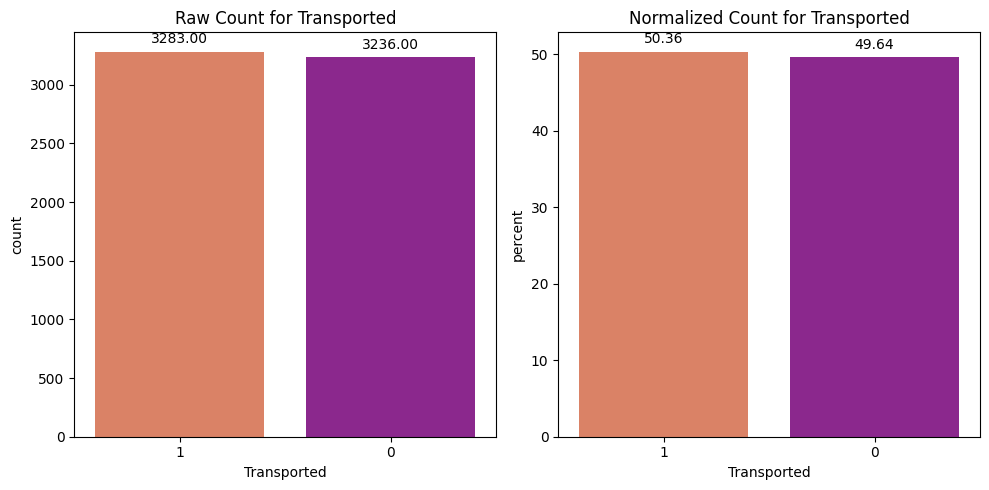

In [16]:
viz.countplot(train_set, cat_col=target, stat='both', show_values=True)

***Comments***:
- Very evenly distributed target classes with a near 50:50 split
- Makes model development more straightforward as no over / under sampling techniques will be required

---
### 1. Univariate Analysis

### i) Categorical Features

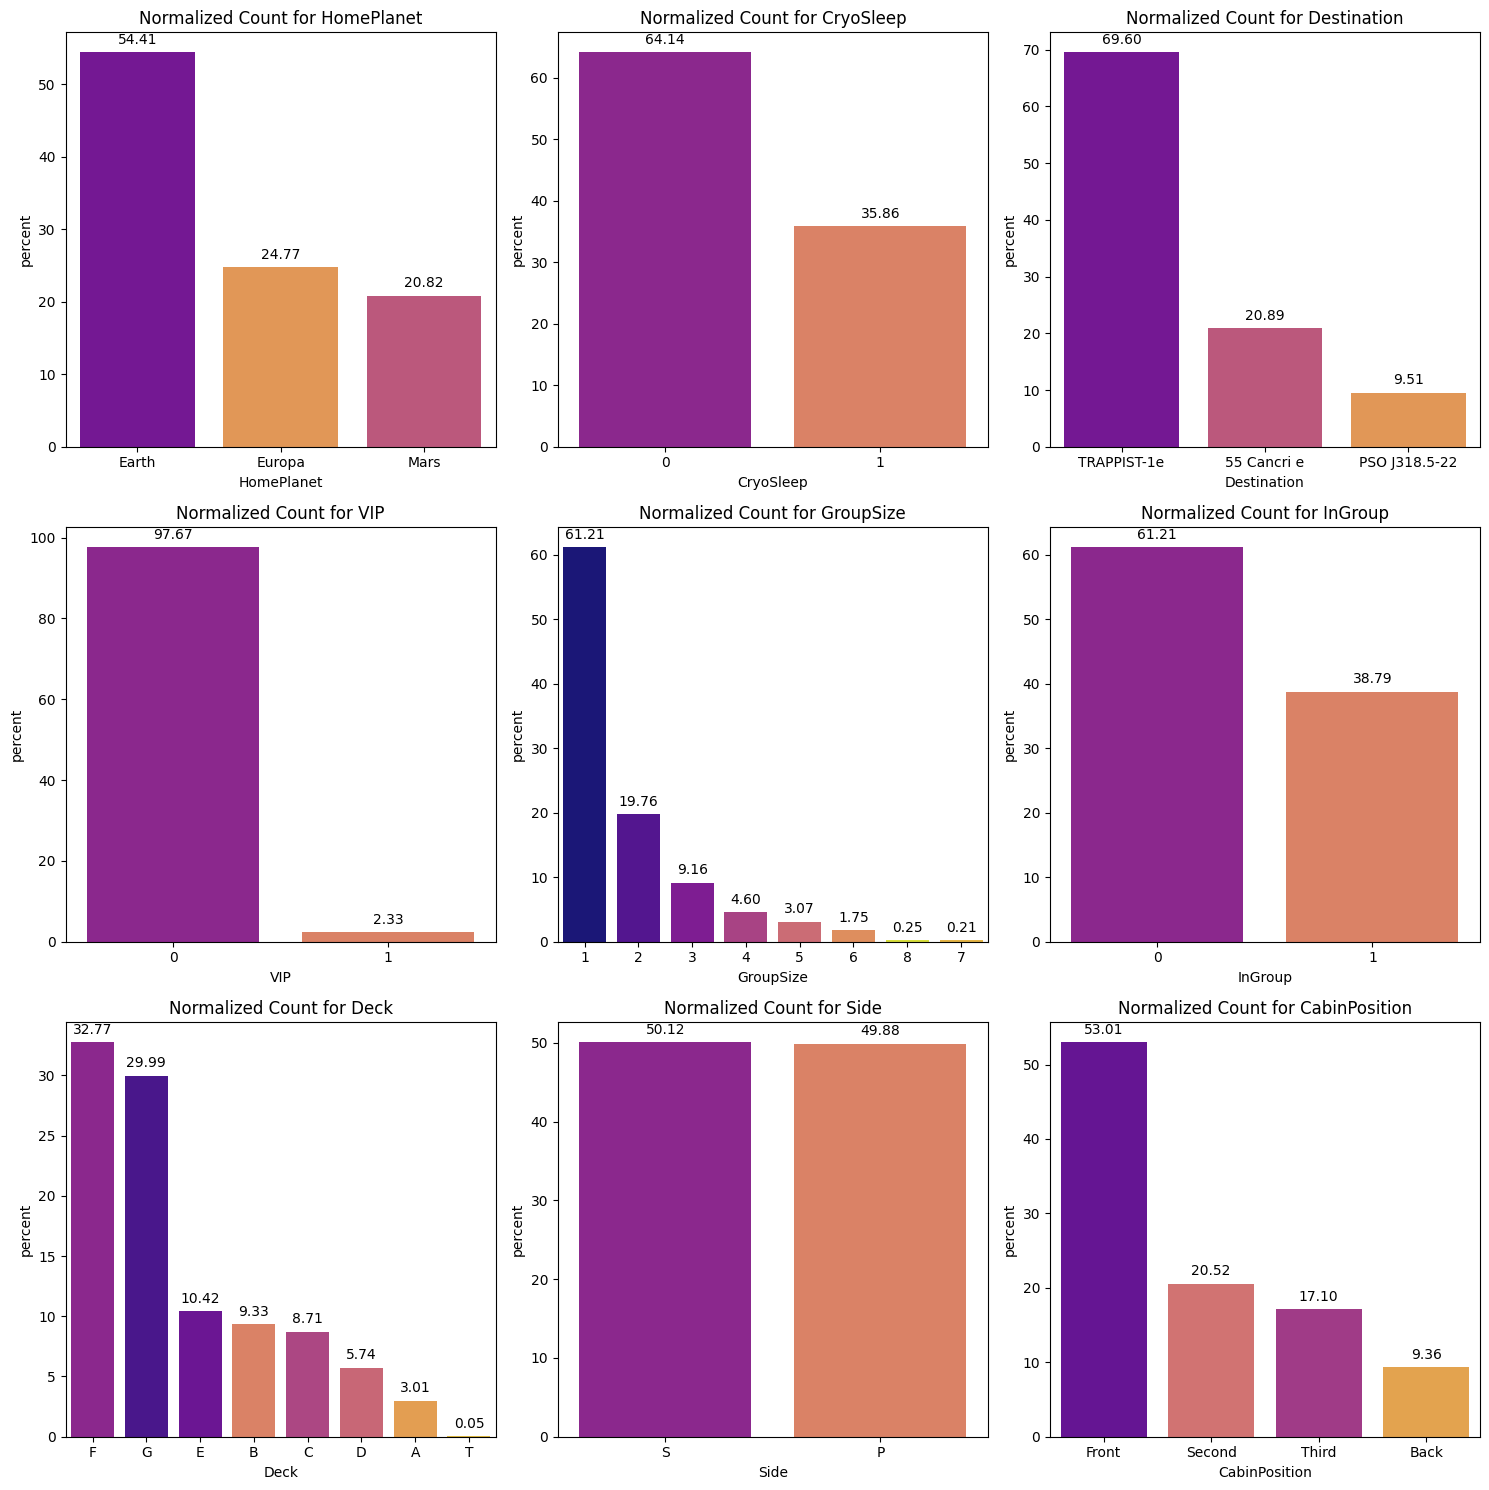

In [17]:
viz.countplot(train_set, cat_col=cat_cols, stat='percent', show_values=True)

## ***Comments / Insights***:

`PassengerId`:  
- Doesn't provide much meaningful info as it is, due to every value being unique, that is this features works as an index for all passengers onboard the ship as the cardinality is 100%. 
- As there were 0 missing values in `PassengerId` and it containes information about if a passenger travelled alone or in a group and the size of the group, I used this feature to extract information that i deemed to be useful to the imputation stage.

`HomePlanet`:  
- 'Earth' is the dominant 'HomePlanet' with 54.4% of the total, then Europa and Mars with 24.8% and 20.8% respectively.

`Destination`:
- 'TRAPPIST-1e' is the most common `Destination` by far with 69.5% of the passengers, followed by '55 Cancri e' and 'PSO J318.5-22' with 20.9% and 9.6% respectively.

`Deck`:
- The majority of the passengers were in cabins on decks 'F' and 'G' (32.9% and 30% resp.)
- Decks E, B, C and D had relatively far fewer passengers (10.3%, 9.4%, 8.7%, 5.7% resp.). Potentially these decks had a combination of cabins and other ameneties (e.g. Shopping Mall, Spa, Food Court) and that's why there are so few passengers compared to decks F and G. Will have to consult the ship's plans to confirm
- There were also 3 passengers travelling on deck T. This seems a little strange and could be an error. Will try to confirm with the company or consider removing these passengers if they have other outlier features.
- Given that there are many different ways 'decks' can be imagined and given names, i am hestiant to make conclusive statments about the location of these decks in relation to the top and bottom of the ship without further clarification. However, i would assume that A is nearer the top and T is at the bottom.

`Cabin Position`:
- For this feature, cabin numbers have been considered from 1 to the highest number on record. The rooms were then divided into 4 equal sections and assigned a label equating to the position on the ship relative to the bow (front).
- Shows a similar pattern of dominance to `Deck` with the majority (52.7%) of passengers in cabin positions in the front or first quarter of the ship.
- The second and third quarters had similar (20.5% and 17.3% resp.) percentage share of the passengers, and the back quarter had the least cabins with passengers (9.5%).

`Side`:  
- There is a very near 50:50 split between port and starboard side cabins. Tiniest difference possibly due to the train, validation split. Indicating passenger cabins were evenly distributed on both sides of the ship.

`VIP`:  
- Very few passengers (2.4%) opted for VIP service on the ship. With such few samples this might become quite a noisy feature to include in modelling.

`CryoSleep`:
- More passengers chose not to be put into cryo sleep for the their trip (61.2%) compared to those that opted for cryo sleep (38.8%).

`InGroup`:
- 61.2% of passengers travelled alone compared to the 38.8% that travelled in a group size between 2 and 7 people.

`GroupSize`:
- Most passengers indicted as travelling alone (61.2%), with 19.8% of passengers travelling with 1 other person and then group sizes diminishing with each aditional group size up to a maximum of 7 passenger groups.

## Ideas to investigate in bivariate analysis

1. How are passengers opting for cryo sleep distributed for `HomePlanet` and `Destination`?
2. Is `GroupSize` better treated as a categorical or a numerical feature?
3. Maybe just include `InGroup` instead of `GroupSize`

---
### ii) Numerical Features Distributions

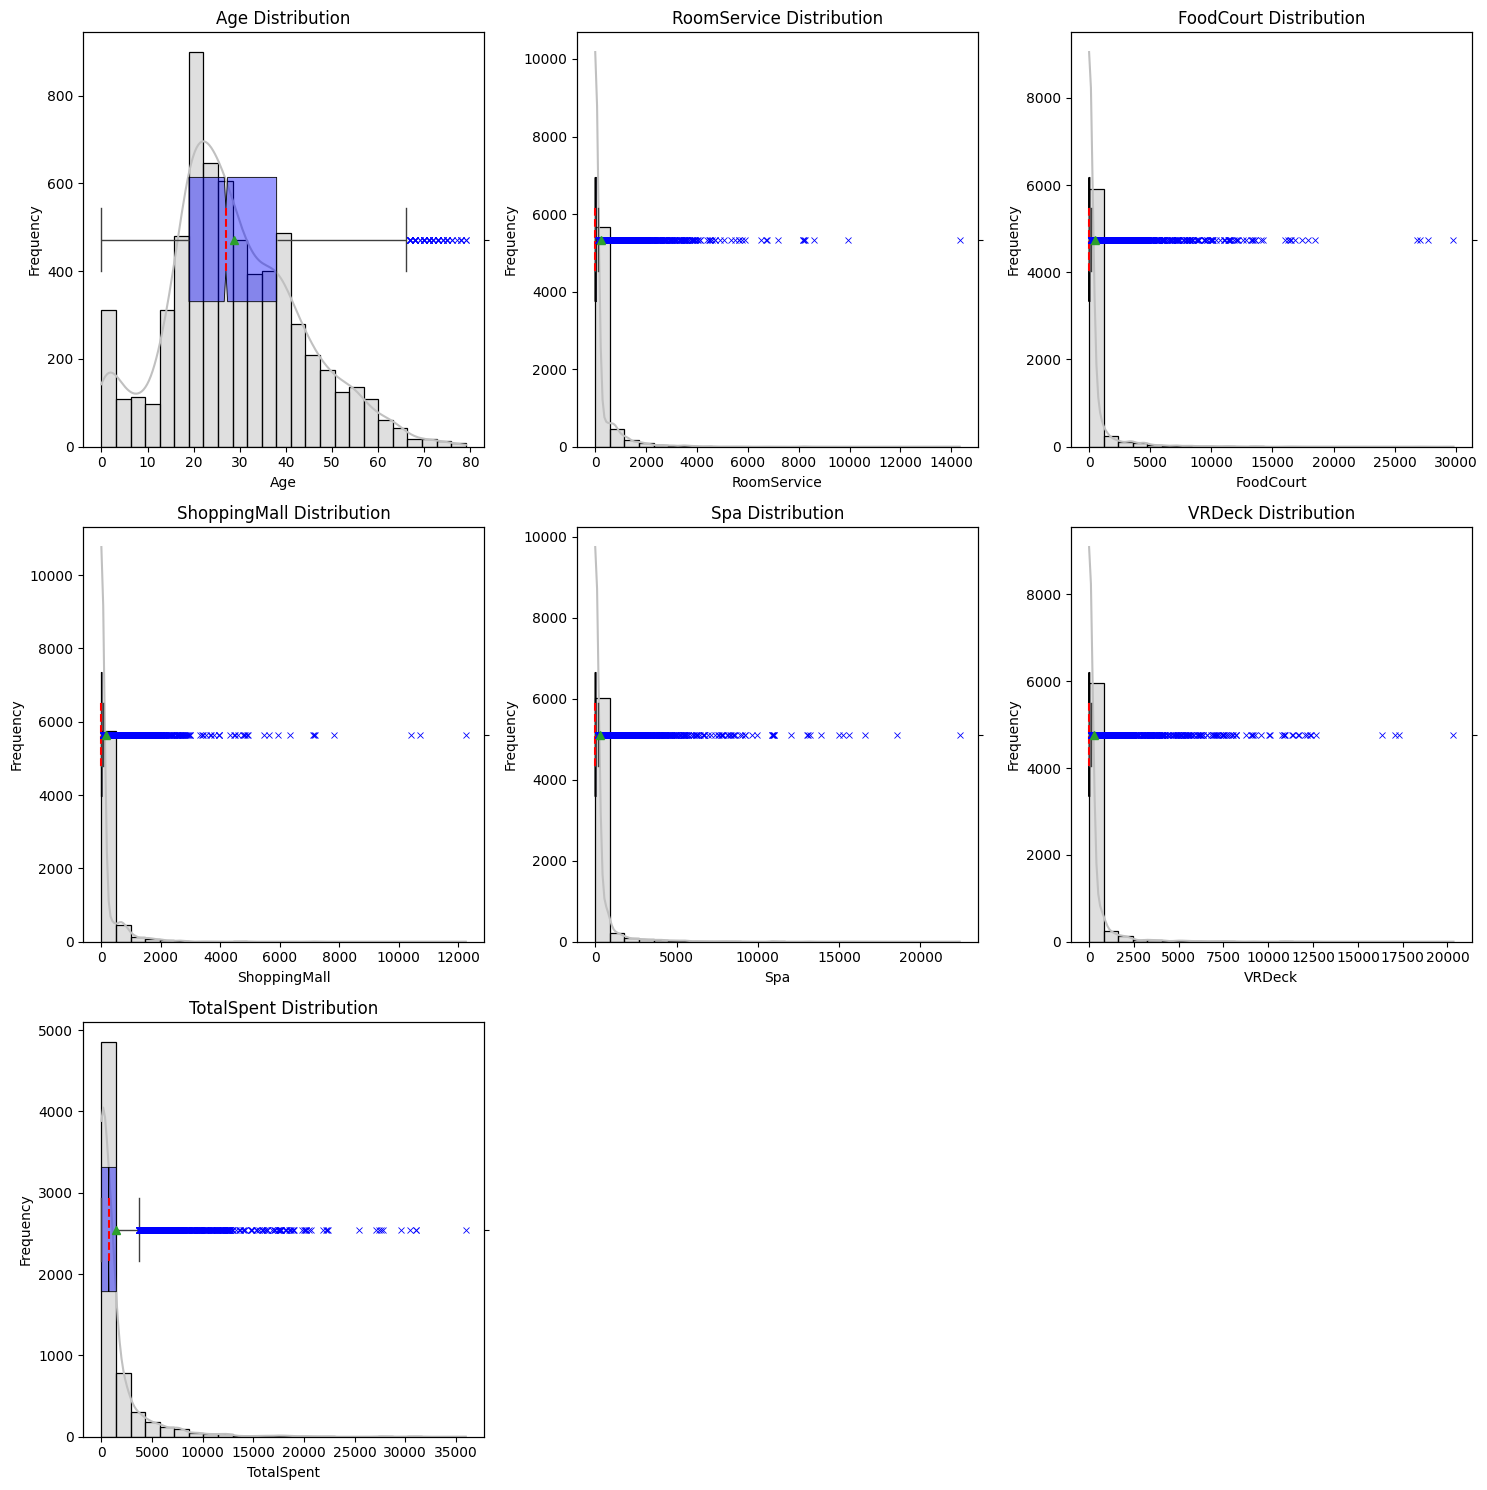

In [18]:
viz.histobox2(train_set, num_cols, kde=True)

### Numerical Features Described

In [19]:
train_set[num_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent
count,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000
mean,28.754686,225.139285,453.643381,171.470563,304.559380,295.723424,1450.536033
std,14.379651,663.839050,1611.965637,548.810574,1125.336877,1098.685930,2765.445497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,722.000000
75%,38.000000,51.000000,76.000000,26.500000,58.000000,46.000000,1481.500000
max,79.000000,14327.000000,29813.000000,12253.000000,22408.000000,20336.000000,35987.000000


## ***Comments / Insights***:

- All numerical data apart from `Age` is heavily right skewed due to a combination of a high presence of zero or close to zero values and numerous high outliers in each feature.
- Given that nearly 40% of the ship were in cryo sleep it seems logical that there is a high presence of zero values in the spending features
- These features provide an ndication that most passengers didn't engage with any extra paid services and spent little to nothing.
- In each feature there are some exceptions that generate a significant minority group with comparatively high spending, e.g the outliers
- The description of the spending feaures provides more insight into the disparity between those that did make use of these services and those that didnt. When comparing the means and the medians of each feature its clear that the outlier groups of spenders are pulling the mean up significantly. This also provides evidence for the need to scale these features for regression based models due to the large differences in means and standard deviations.

## ***Transformations / Ideas***:

- Due to the highly skewed distributions of these features, they will require some transformation for them to offer value to any models that are regression based. Regression based algorithms assume that features (and target if continuous) will have an approximately gaussian distribution.
- This will have a large impace on variance and therefore the sum of least squares, which will likely reduce the overall explainability of the data.

1. Split even service's spending into outliers and normal spenders
    - consider how to best transform each groups spending and model each group's spending separately
    - join up the outcomes
2. I will visualize several transformations to try to achieve a more gausian distribution
3. Bin spending features into groups

---
## Splitting Service Spenders into Outlier and Non-Outlier Groups

Define a list 'services' to use later if i want to remove these columns from modelling

In [20]:
services = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [21]:
iqr_limits = {col: train_set[col].quantile(0.75) + 1.5 * (train_set[col].quantile(0.75) - train_set[col].quantile(0.25)) for col in services}

for col in num_cols:
    if col not in ['Age', 'TotalSpent']:
        train_set[f'{col}_used'] = train_set[col].apply(lambda x: 1 if x > 0 else 0).astype(int)

        outlier_limit = iqr_limits[col]
        train_set[f'{col}_big_spender'] = train_set[col].apply(lambda x: 1 if x > outlier_limit else 0).astype(int)

In [22]:
services_used = [col for col in train_set.columns if 'used' in col]
big_spenders = [col for col in train_set.columns if 'big_spender' in col]

In [23]:
# train_set[train_set[big_spenders].any(axis=1)]

Passengers that are outliers in at least one of the big spender columns account for nearly 58% of the train_set. No sense in removing these outliers to try to get a more gaussian distribution of numerical features

***Revised Ideas***:
- Create binary features for big spenders (outliers) and whether a passenger used the service at all.
- Decide whether to:
    - Consider dropping the numerical columns (apart from age and total spent).
    - Split outliers from the dataset into a separate dataset and model separately.
    - Try both methods
- Most likely going to cause some colinearity which regression based models are not going to like 
- Will try modelling with all ideas and also leaving everything in.

## Distributions of service_used features

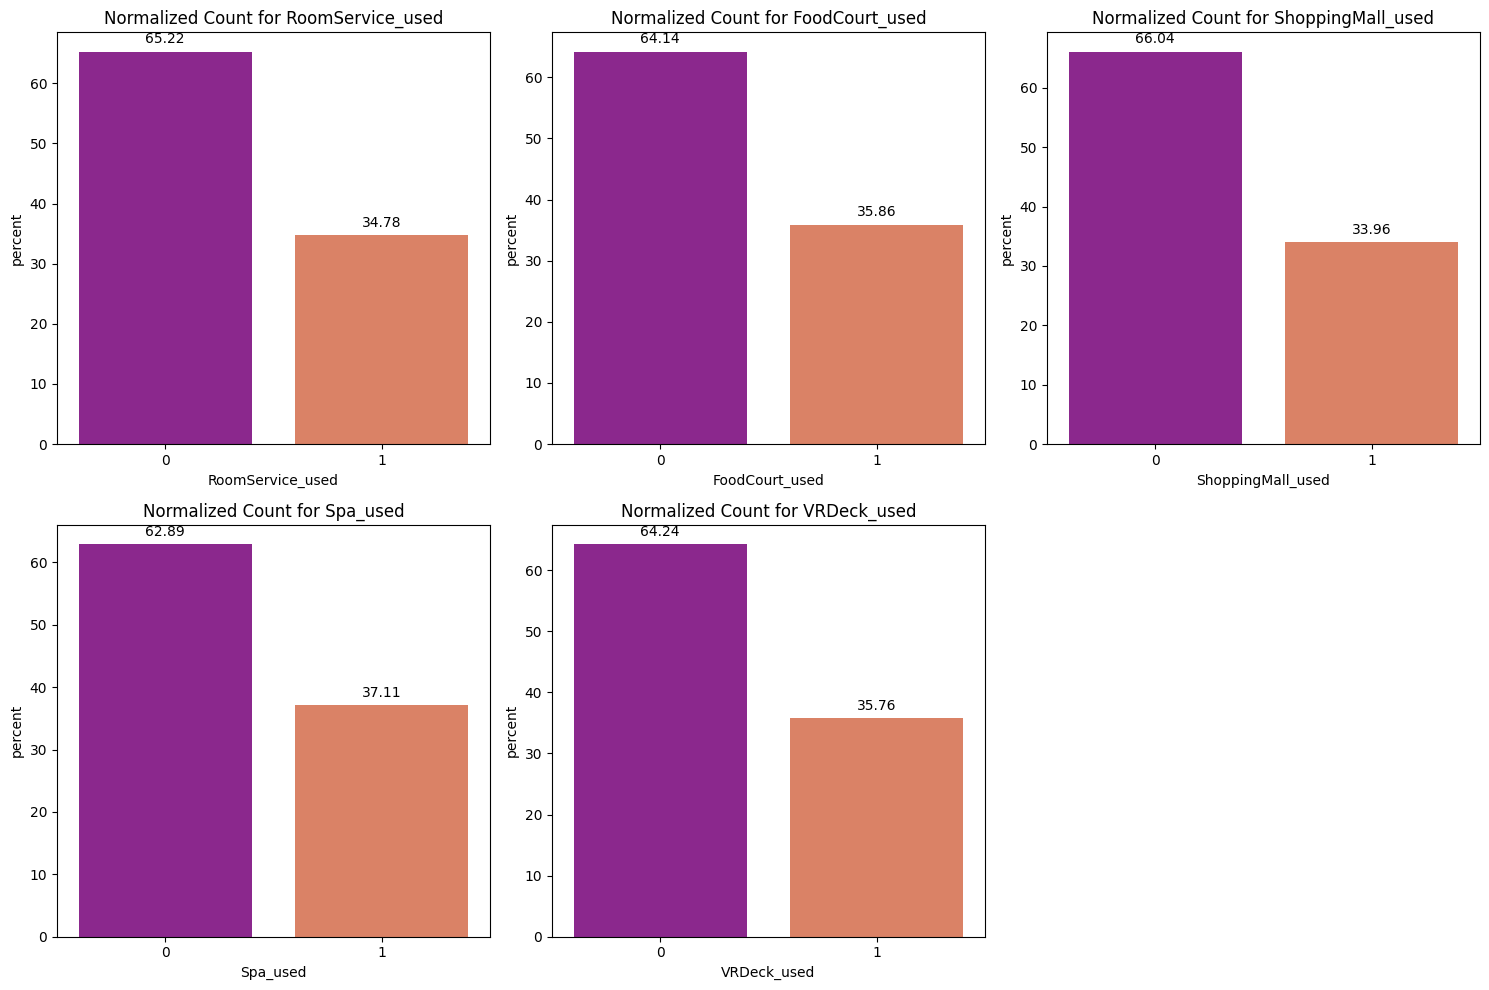

In [24]:
viz.countplot(train_set, cat_col=services_used, stat='percent', show_values=True, max_cols=3)

## big_spenders (outliers) vs. normal_spender distributions for each service

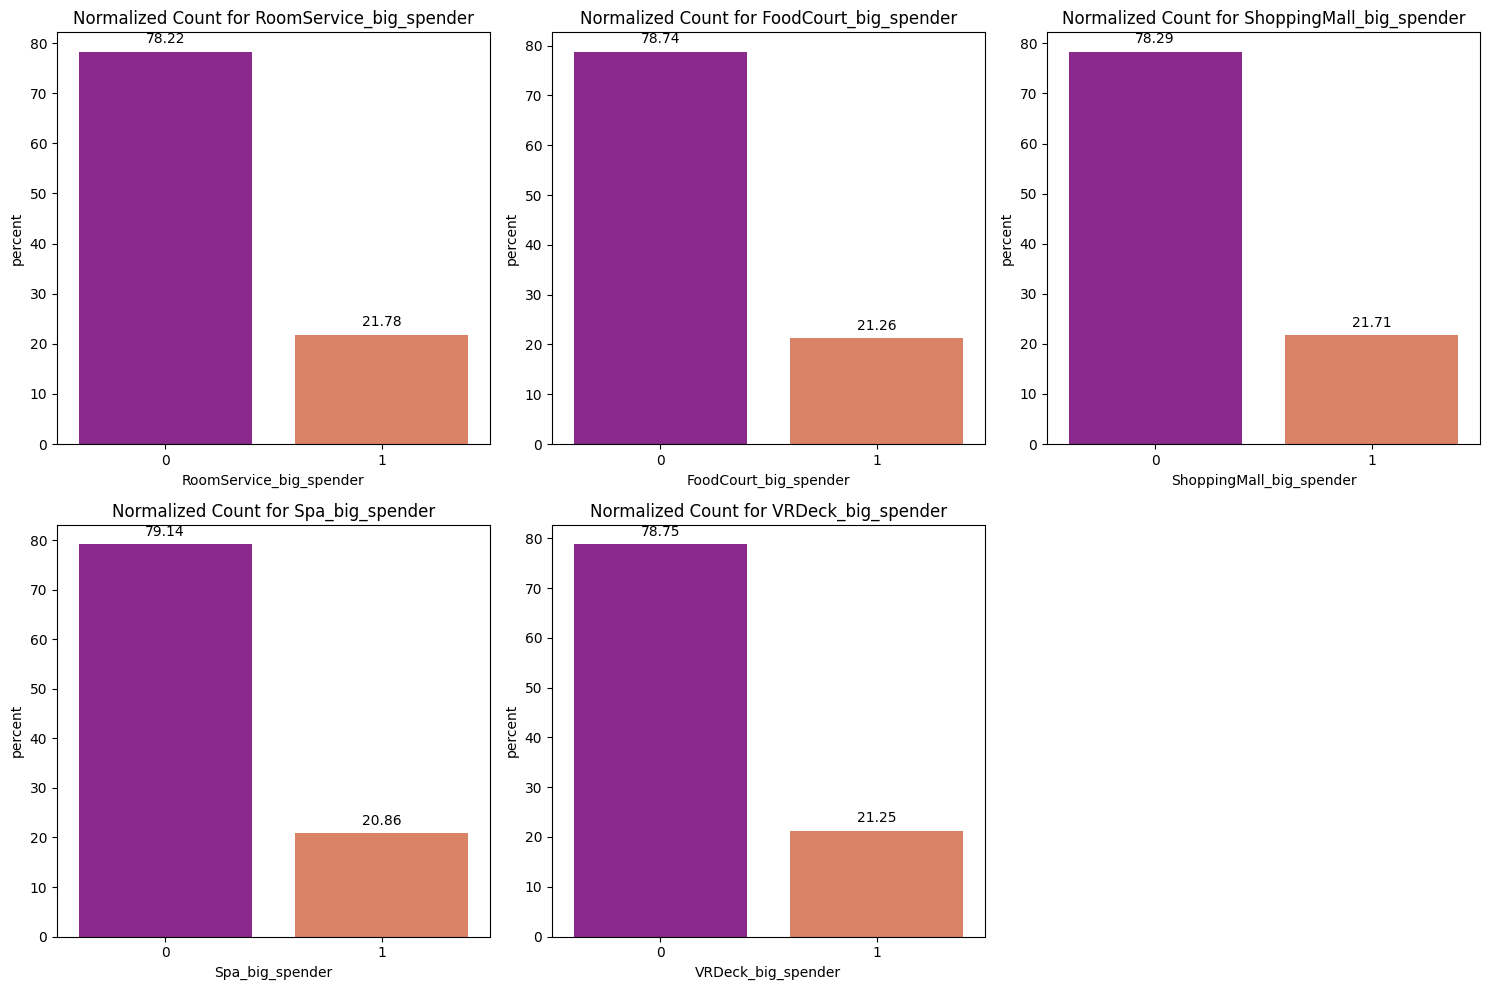

In [25]:
viz.countplot(train_set, cat_col=big_spenders, stat='percent', show_values=True, max_cols=3)

I will likely need to make a decision about whether the big_spender features or the service_used features have a better association with the target to help remove some colinearity issues from the model.

The above graphics indicate that for the service_used features there is a similar distribution of passengers that did/didn't use the service for all services/ameneties.
Similarly, the outlier vs non-outlier spenders for each service have very similar distributions for each service.

In [26]:
roomServiceOutliers = train_set['RoomService_big_spender'] == 1
roomServiceNormal = ((train_set['RoomService_big_spender'] == 0) & (train_set['RoomService'] > 0))

foodCourtOutliers = train_set['FoodCourt_big_spender'] == 1
foodCourtNormal = (train_set['FoodCourt_big_spender'] == 0 & (train_set['FoodCourt'] > 0))

shoppingMallOutliers = train_set['ShoppingMall_big_spender'] == 1
shoppingMallNormal = (train_set['ShoppingMall_big_spender'] == 0 & (train_set['ShoppingMall'] > 0))

spaOutliers = train_set['Spa_big_spender'] == 1
spaNormal = (train_set['Spa_big_spender'] == 0 & (train_set['Spa'] > 0))

vrDeckOutliers = train_set['VRDeck_big_spender'] == 1
vrDeckNormal = (train_set['VRDeck_big_spender'] == 0 & (train_set['VRDeck'] > 0))

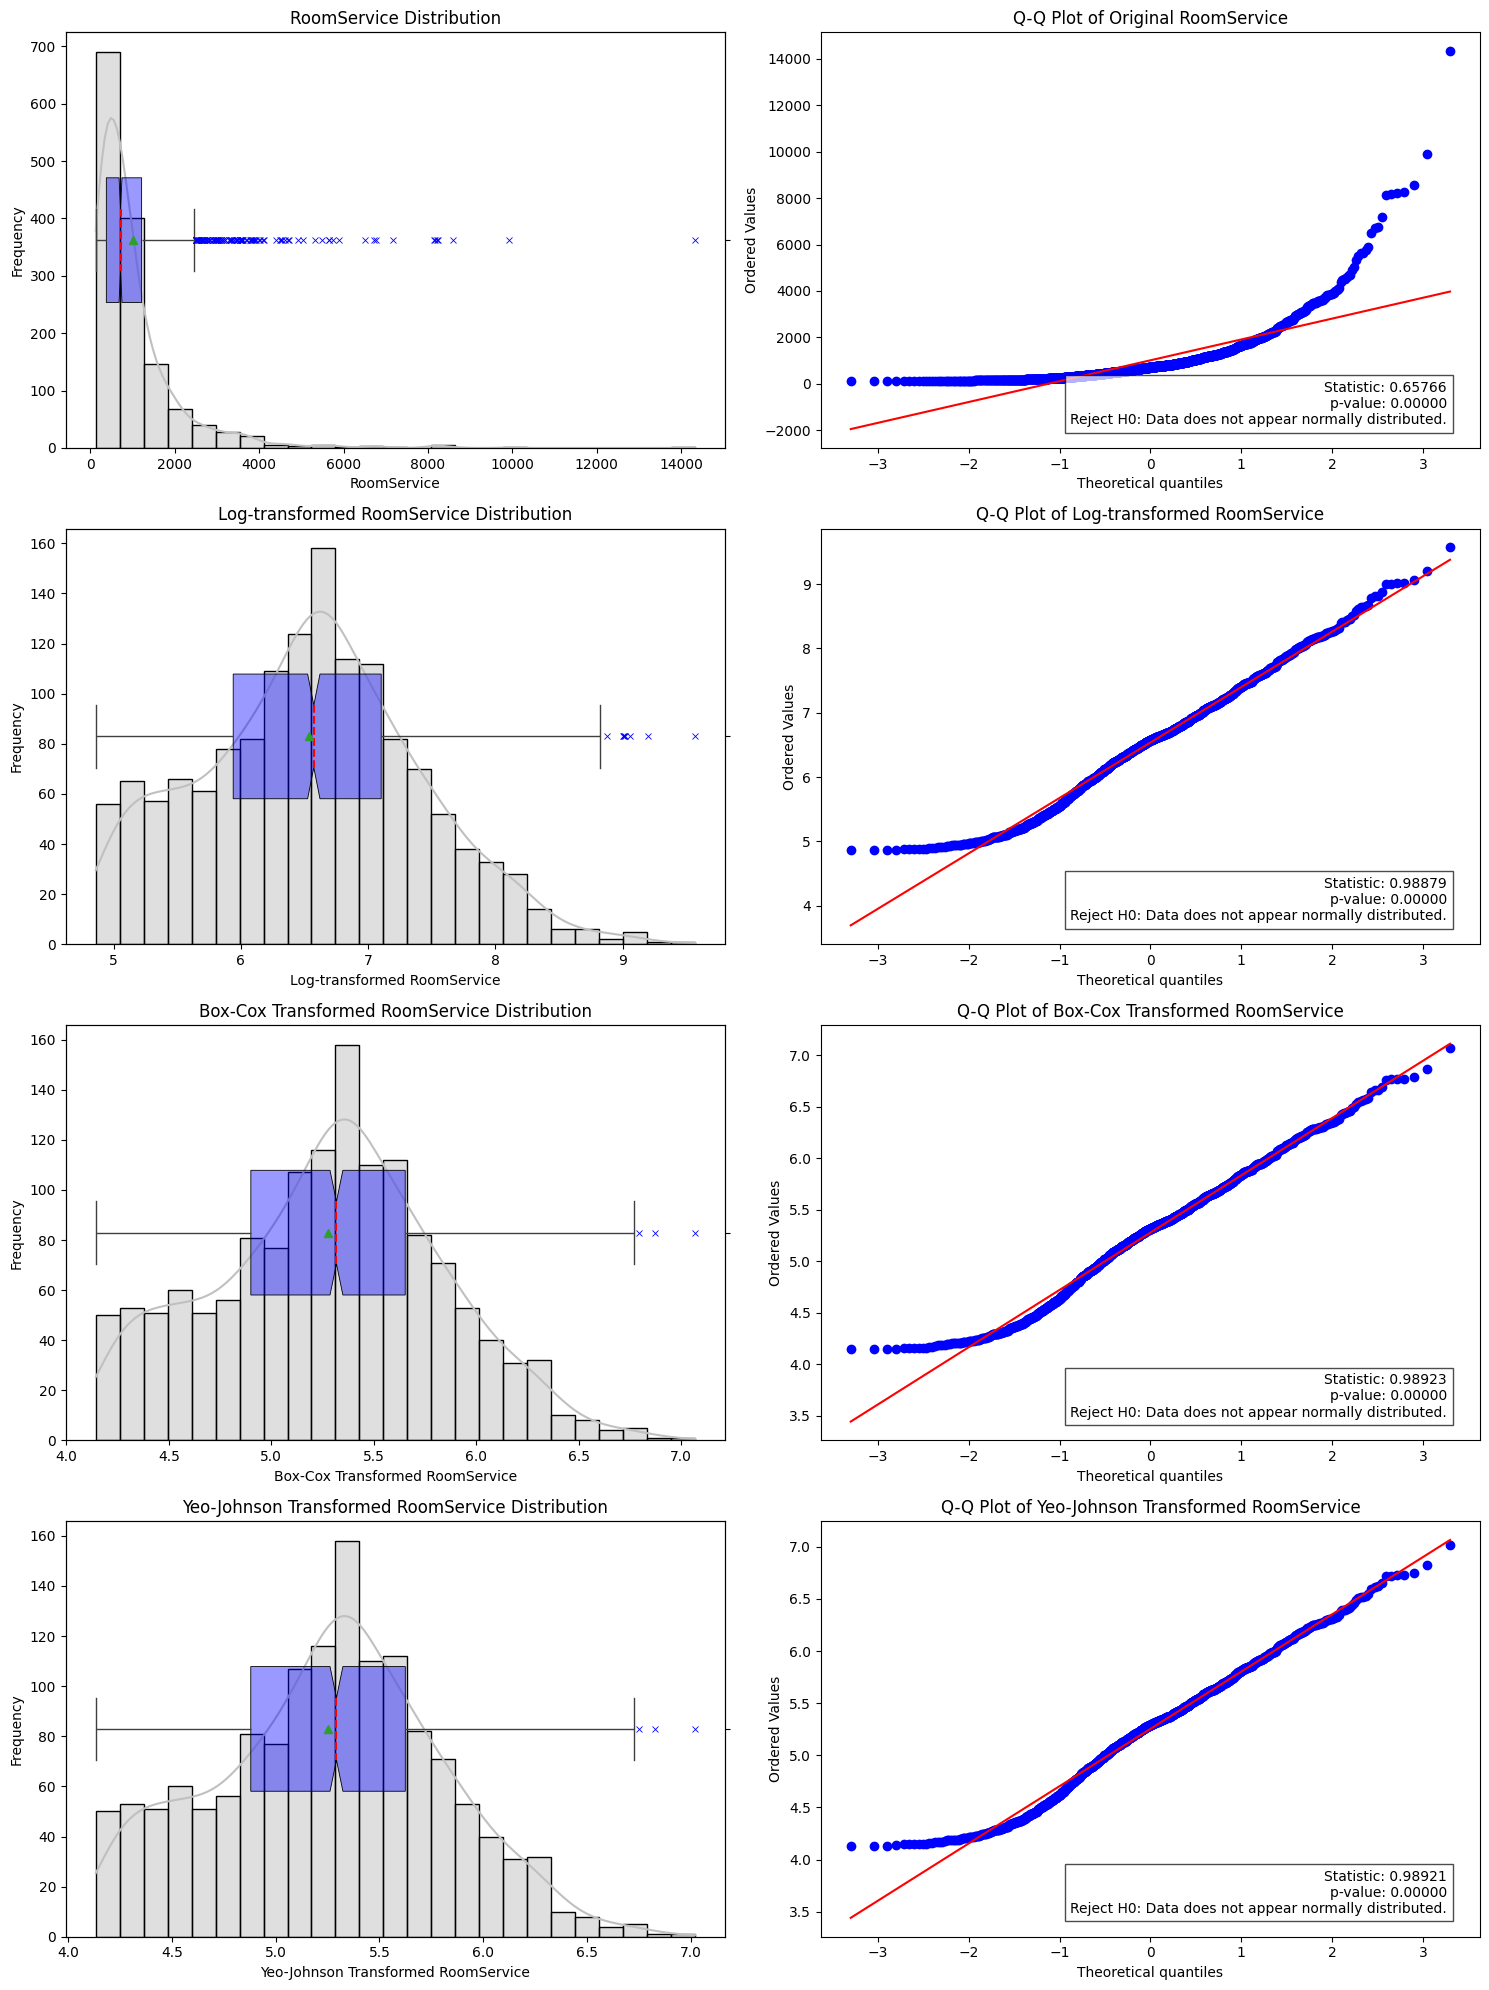

In [27]:
viz.transform_distributions(train_set[roomServiceOutliers], 'RoomService', transformations=('log','boxcox','yeo-johnson'))

---

In [28]:
# refresh the cat and num_cols lists
info_df = mlt.describe_and_suggest(train_set)
cat_cols = info_df[info_df['Suggested Type'].isin(['Categorical', 'Binary'])].index.to_list()
num_cols = info_df[info_df['Suggested Type'].isin(['Numerical Discrete', 'Numerical Continuous'])].index.to_list()
cat_cols.remove('Transported')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519 entries, 0 to 6518
Data columns (total 27 columns)
dtypes: int64(15), float64(7), object(5)
memory usage: 2879.7 KB

Total Percentage of Null Values: 0.00%


In [29]:
# View the modal passenger for categorical features
train_set[cat_cols].mode().T

,0
HomePlanet,Earth
CryoSleep,0
Destination,TRAPPIST-1e
VIP,0
GroupSize,1
InGroup,0
Deck,F
Side,S
CabinPosition,Front
RoomService_used,0


---
## Bivariate Analysis with Target

#### Categorical Features

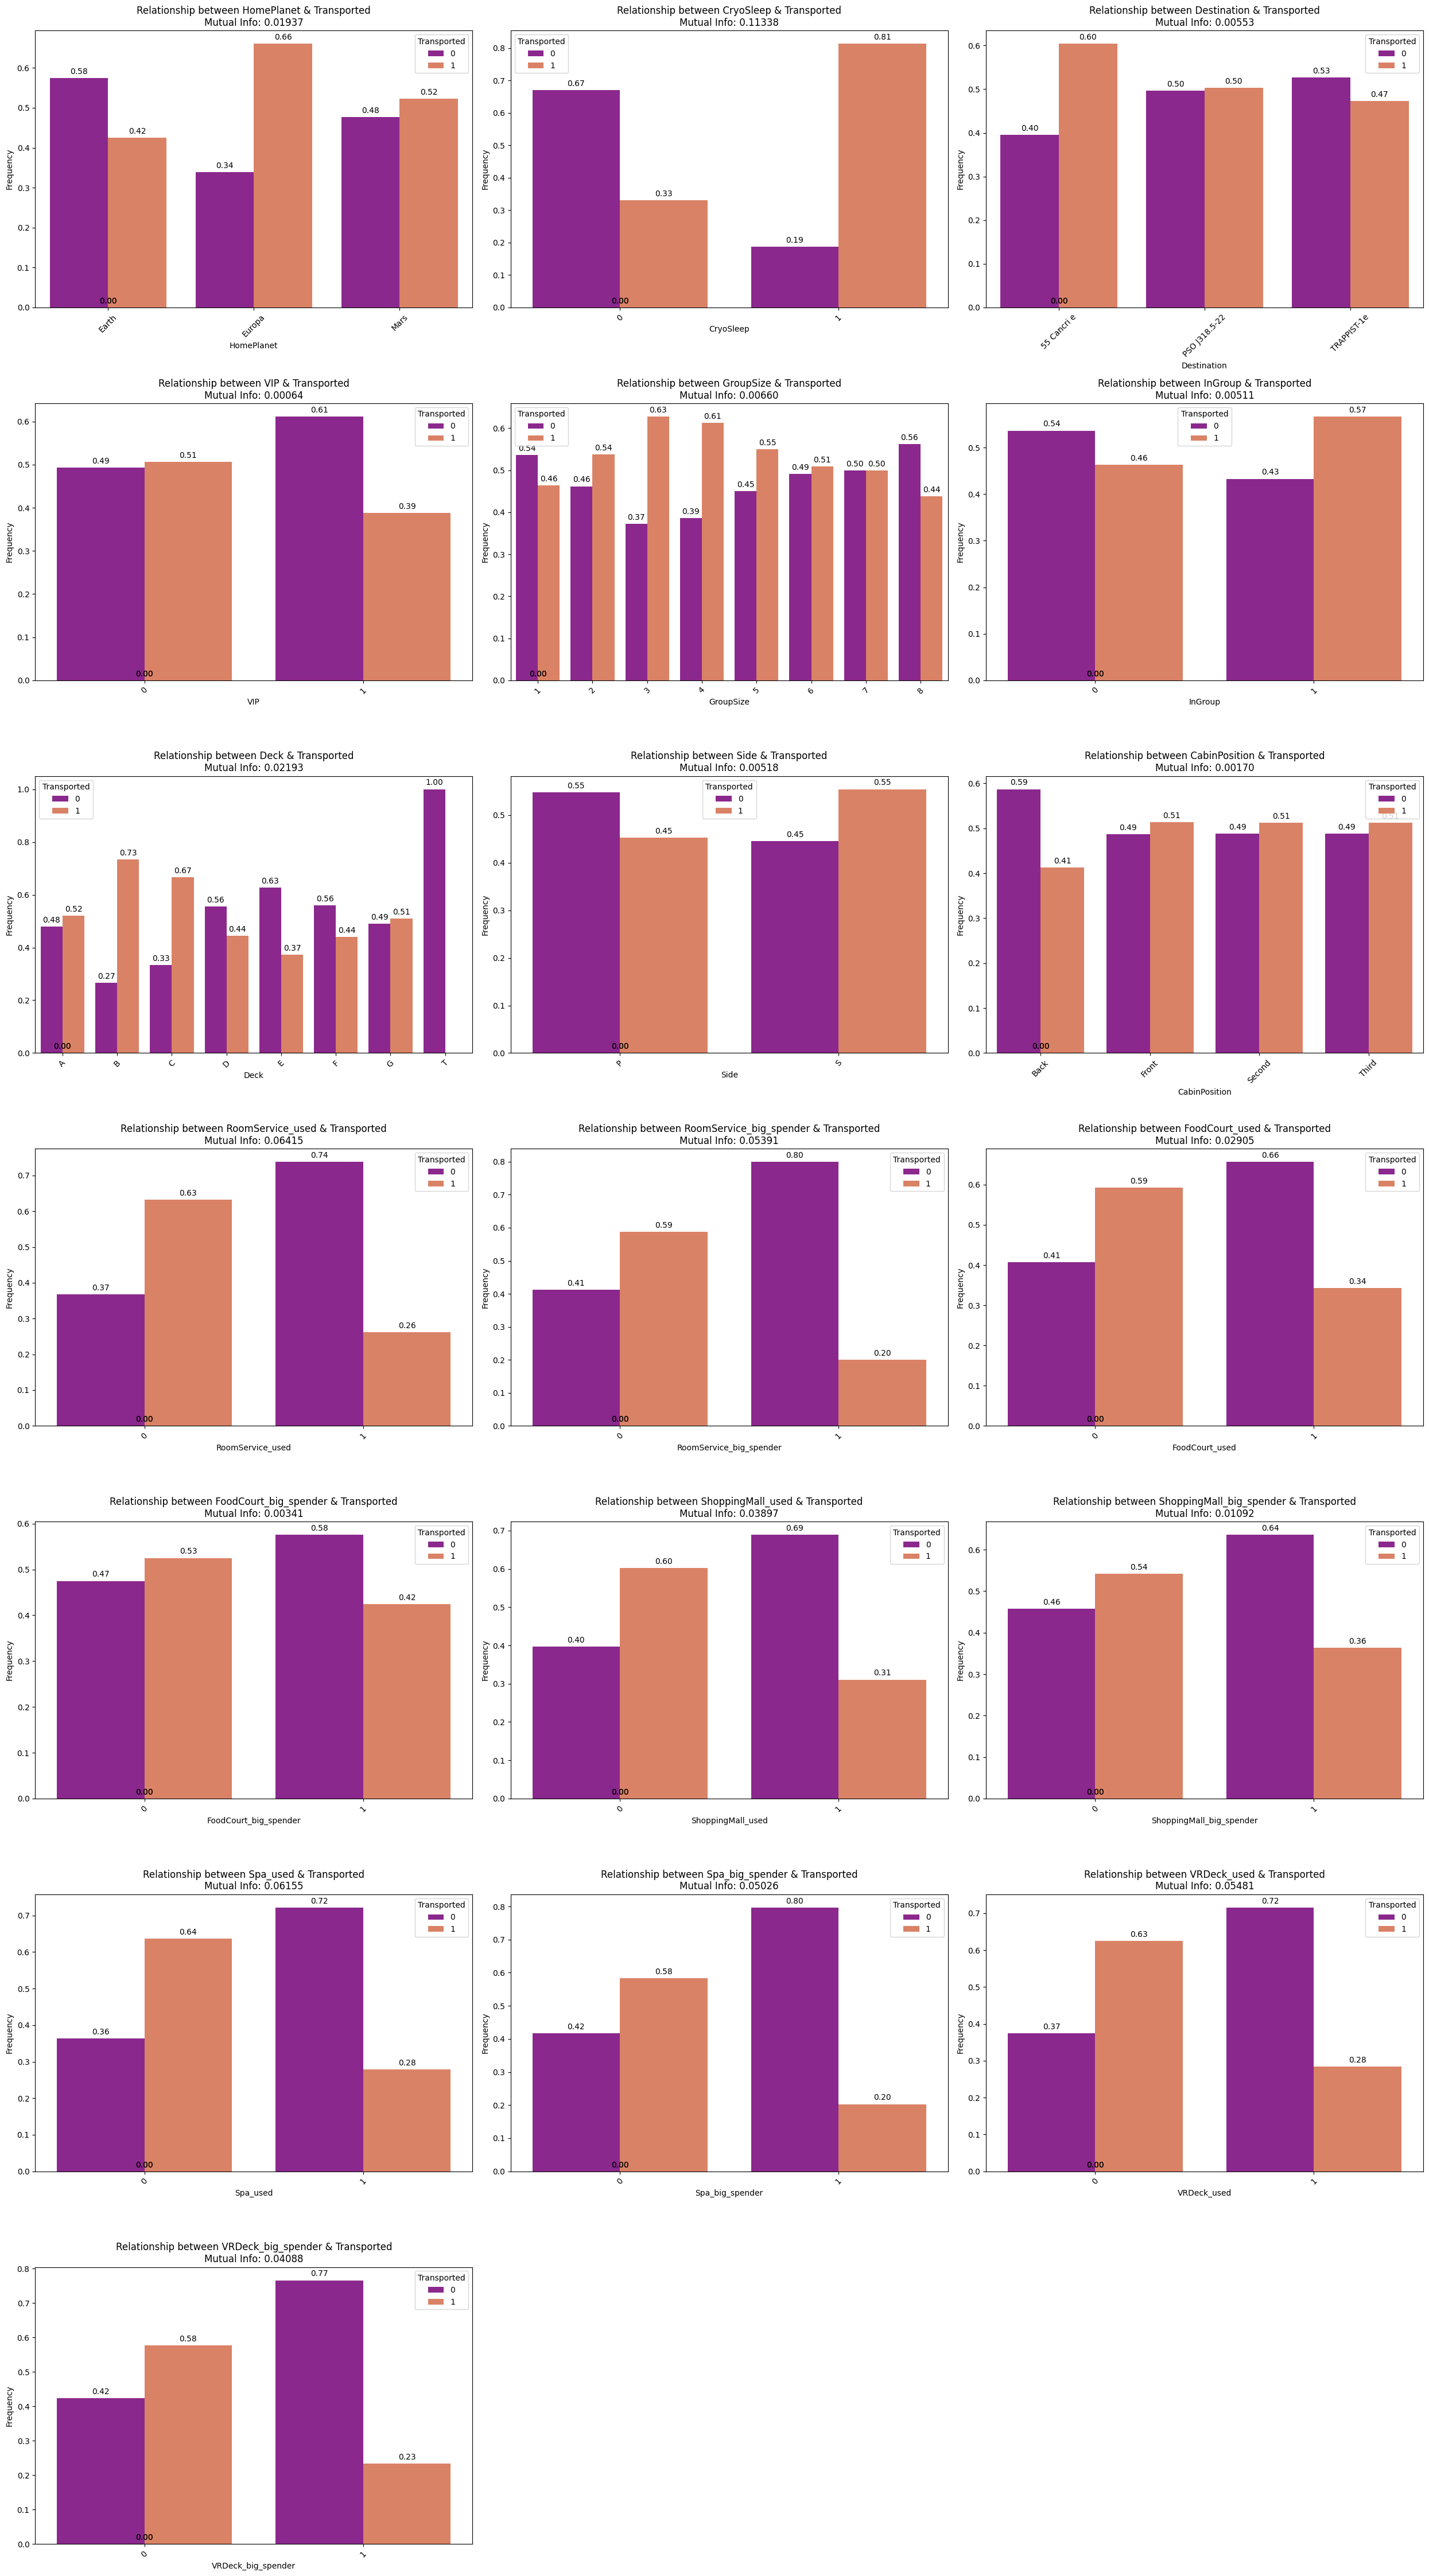

In [30]:
fig, axes = plt.subplots(7, 3, figsize=(25, 45))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    viz.categorical_relationships(train_set, col, 'Transported', relative_freq=True, show_values=True, group_size=8, ax=axes[i])

if len(cat_cols) < len(axes):
    for j in range(len(cat_cols), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

## Comments and Insights:

- 
- 
- 
- 


---
## Numerical variables with Target

- As we have already seen that the distributions of the numerical features is nowhere near gaussian and looking pretty horrendous, not likely to be able to discern much useful information from grouped histograms or side-by-side boxplots. The previous graphics showing histograms with overlaid boxplots indicate that even the boxplots are not going to show much useful info due to the high presence of zero values.
- As such, i'm going to investigate the outliers distributions and thos not considered outliers separatley

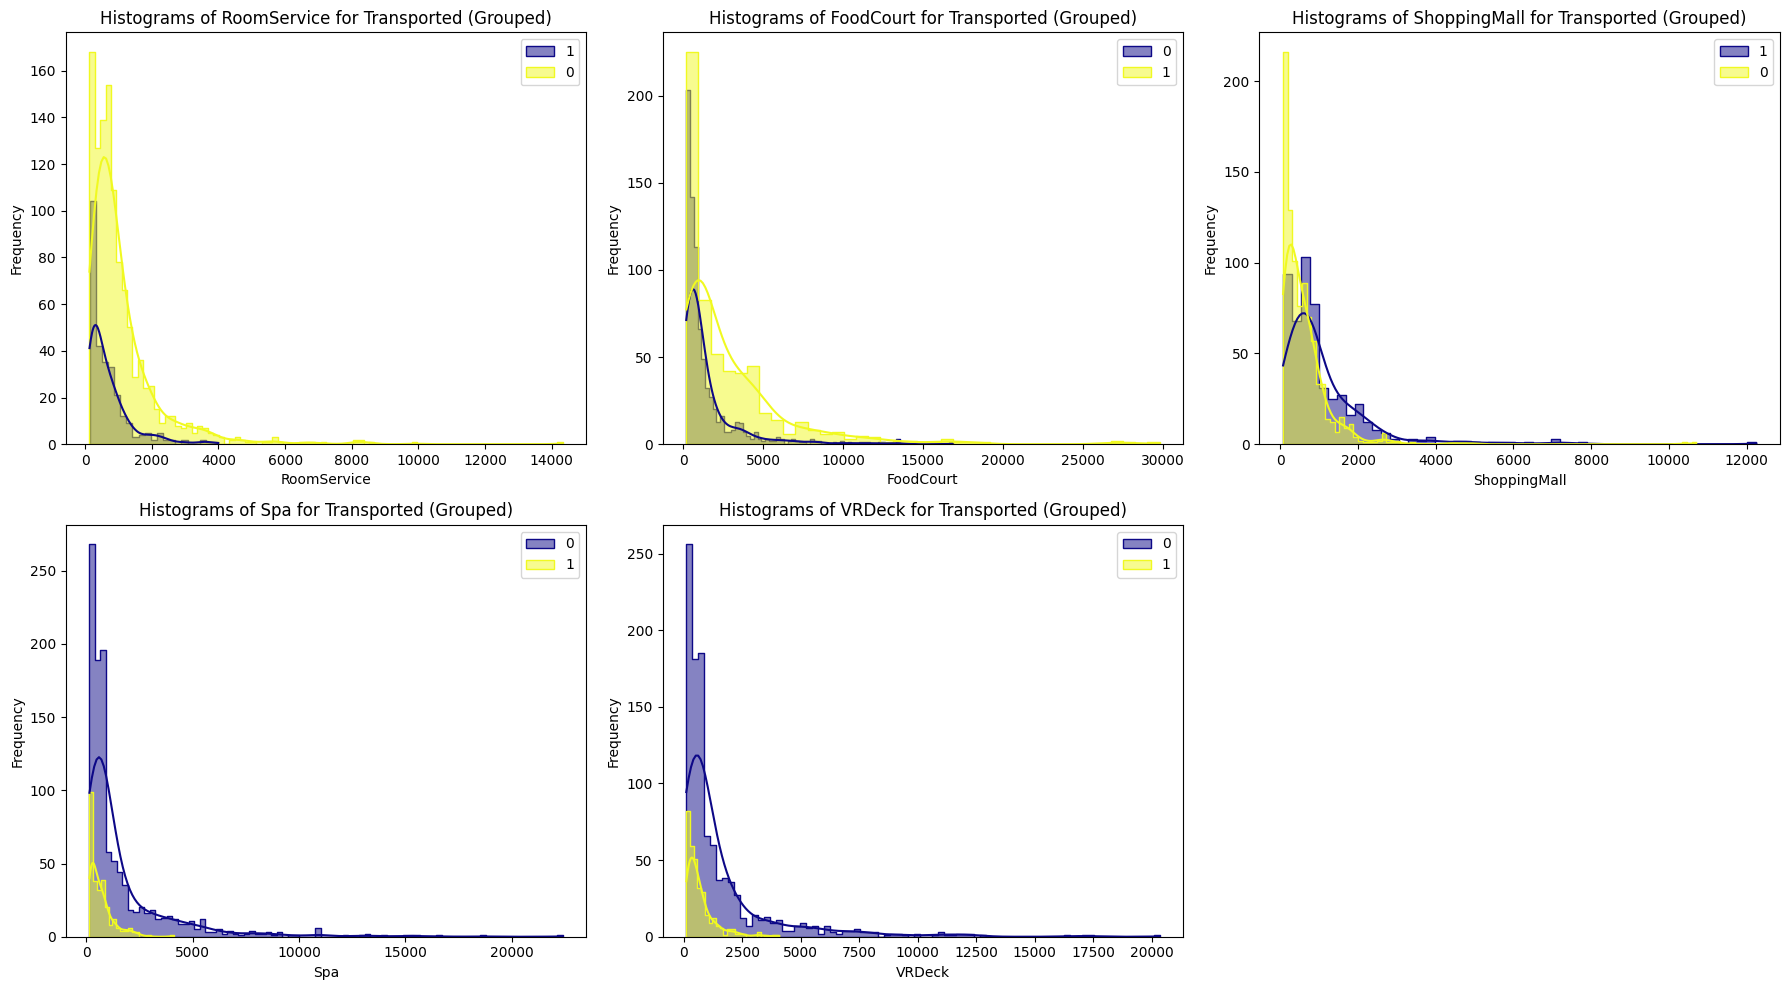

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

viz.grouped_histograms(train_set[roomServiceOutliers],target, 'RoomService', kde=True, ax=axes[0])
viz.grouped_histograms(train_set[foodCourtOutliers],target, 'FoodCourt', kde=True, ax=axes[1])
viz.grouped_histograms(train_set[shoppingMallOutliers],target, 'ShoppingMall', kde=True, ax=axes[2])
viz.grouped_histograms(train_set[spaOutliers],target, 'Spa', kde=True, ax=axes[3])
viz.grouped_histograms(train_set[vrDeckOutliers],target, 'VRDeck', kde=True, ax=axes[4])

axes[5].axis('off')
plt.tight_layout()
plt.show()

### Comments / Insights:

- In all of the outlier groups, higher spending seems to have a stronger relationship with being Transported off the ship
- `RoomService` is the exception to this, which maybe points to the Transported off the ship issue being linked to being in the Cabin. If passengers spent more on amenety services is seems logical that they spent more time out of their rooms and therfore were less likely to have been Transported off the ship.


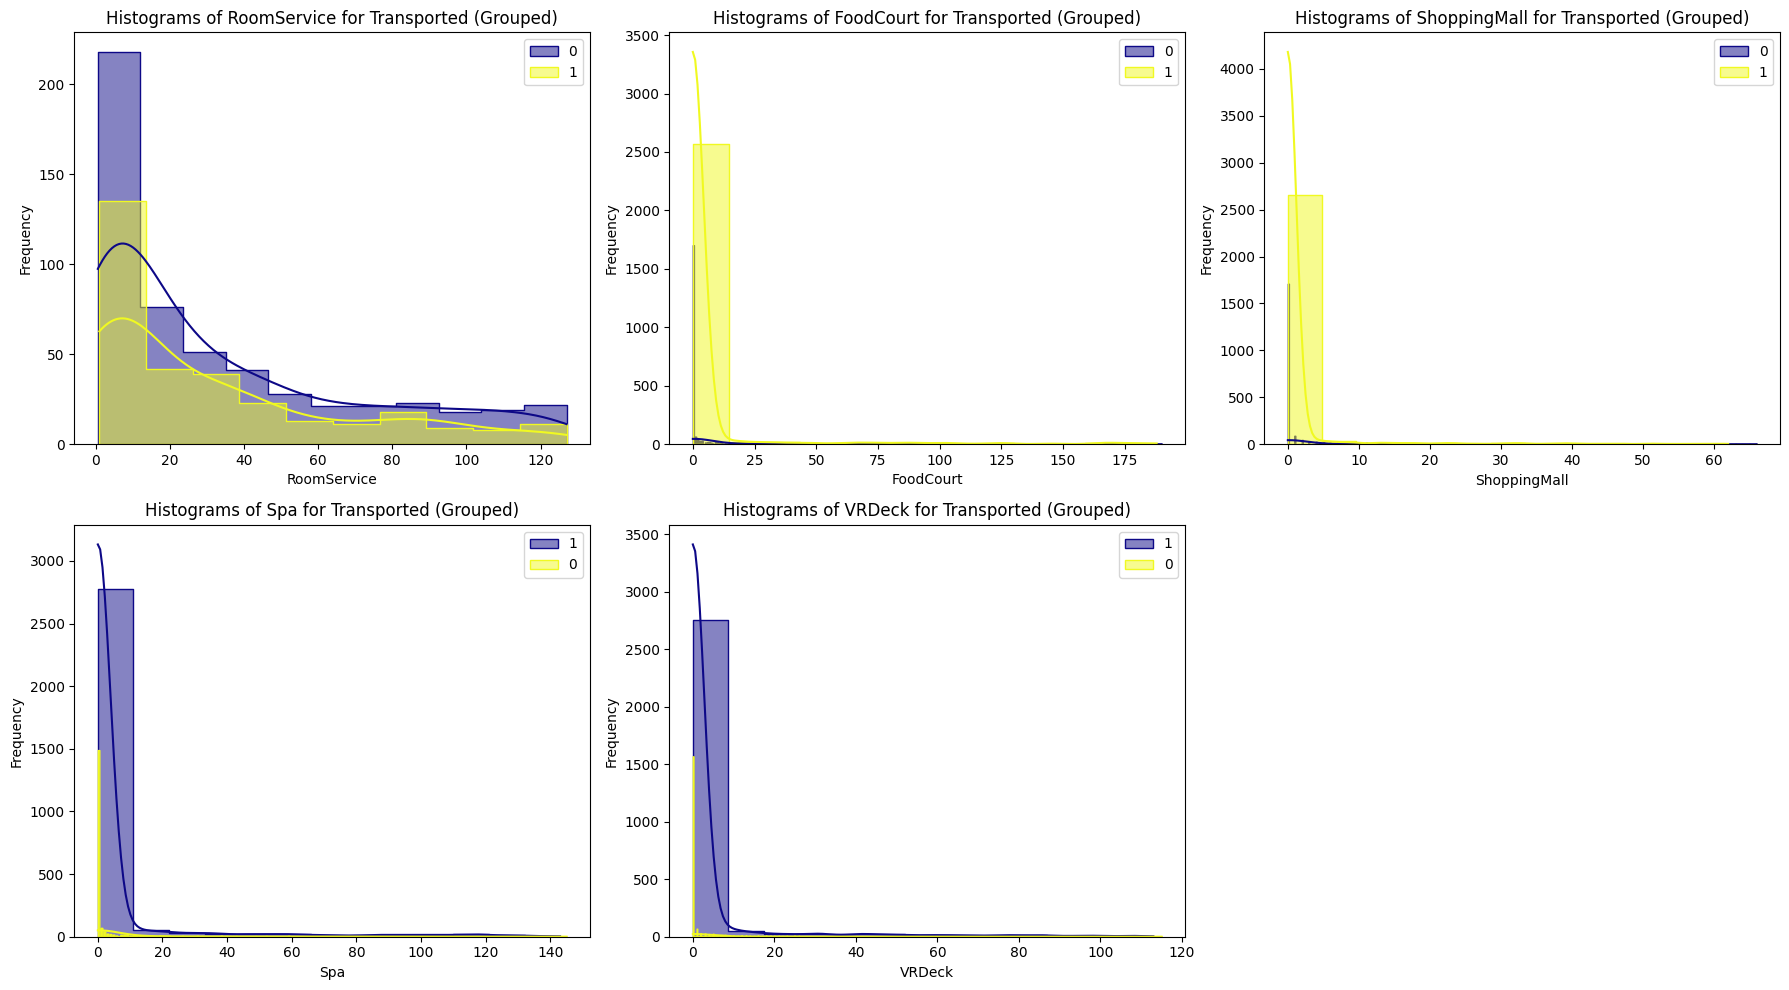

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

viz.grouped_histograms(train_set[roomServiceNormal],target, 'RoomService', kde=True, ax=axes[0])
viz.grouped_histograms(train_set[foodCourtNormal],target, 'FoodCourt', kde=True, ax=axes[1])
viz.grouped_histograms(train_set[shoppingMallNormal],target, 'ShoppingMall', kde=True, ax=axes[2])
viz.grouped_histograms(train_set[spaNormal],target, 'Spa', kde=True, ax=axes[3])
viz.grouped_histograms(train_set[vrDeckNormal],target, 'VRDeck', kde=True, ax=axes[4])

axes[5].axis('off')
plt.tight_layout()
plt.show()

### Comments / Insights:

- In all of the Non-outlier groups, it is still quite hard to visualize how the distributions vary between passengers that were transported off the ship and those that were not.
- However, the same pattern as with the outliers seems to be peaking through and that higher spending on any of the ameneties appears to indicate more chance of being Transported off the ship.
- The exception again is `RoomService` which appears to show the opposite pattern. Again pointing to an issue with passenger cabins.

---
---
## Model Selection

Going to build models based on the following algorithms:
- Logisitic Regression
- Random Forest Classifier
- LightGBM Classifier
- XGBM Classifier
- Catboost Classifier

I will also experiment with:
- Voting classifiers
- Stacking Classifiers
- Combinations of voting and stacking classifiers built from combinations of above models

In [21]:
# The following variables will be used in the final pipelines
proportional_impute_cols = ['Destination','Deck','Side','CabinPosition','VIP','CryoSleep']
knnimputer_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition']
binary_cols = ['VIP','CryoSleep','InGroup']
num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']
polynomial_feats = ['TotalSpent']

In [22]:
lr = LogisticRegression(C=1)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
xgbm = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
catb = CatBoostClassifier(iterations=100, depth=5, cat_features=cat_cols, l2_leaf_reg=2)
svm = SVC(C=1, kernel='sigmoid', gamma='scale')

models = {'lr':lr, 'rf':rf, 'lgbm':lgbm, 'xgbm':xgbm, 'catb':catb}

---
---
## Pipeline

1. Create functions for use with FunctionTransformers

In [23]:
# Transform 'PassengerId'
def transform_passengerId(df):
    df['GroupId'] = df['PassengerId'].str.split('_').str[0]
    df['PassengerNumber'] = df['PassengerId'].str.split('_').str[1].astype(float)
    group_counts = df['GroupId'].value_counts()
    df['GroupSize'] = df['GroupId'].map(group_counts)
    df['InGroup'] = np.where(df['GroupSize'] > 1, 1, 0)
    return df

# Transform 'Cabin'
def transform_Cabin(df):
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Side'] = df['Cabin'].str.split('/').str[2]
    bin_edges = np.linspace(df['CabinNumber'].min(), df['CabinNumber'].max(), 5)
    df['CabinPosition'] = pd.cut(df['CabinNumber'],
                                 bins=bin_edges,
                                 labels=['Front','Second','Third','Back'],
                                 include_lowest=True)
    return df

# Imputations for NaNs in 'HomePlanet'
def impute_homePlanet(df):
    group_modes = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = group_modes[df['HomePlanet'].isna()]

    deck_modes = df.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[df['HomePlanet'].isna()]

    if 'VIP' in df.columns:
        vip_mode_homePlanet = df.loc[df['VIP'] == True, 'HomePlanet'].mode().iloc[0]
        df.loc[df['VIP'] & df['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

    df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0], inplace=True)

    return df

# Proportional imputer for categorical columns
def proportional_imputer(df, impute_cols):
    for col in impute_cols:
        proportions = df.groupby('HomePlanet')[col].value_counts(normalize=True)

        def impute_values(row):
            if pd.isna(row[col]):
                group = row['HomePlanet']
                if pd.notna(group) and group in proportions.index:
                    group_proportions = proportions.loc[group].dropna()
                    return np.random.choice(group_proportions.index, p=group_proportions.values)
            return row[col]
        
        # Apply the impute function to each column
        df[col] = df.apply(impute_values, axis=1)
    return df

# KNN imputation for numerical columns
def knn_imputer(df, columns):
    imputer = KNNImputer(n_neighbors=5)
    df[columns] = imputer.fit_transform(df[columns])
    return df

# Create 'TotalSpent' feature
def create_totalSpent(df):
    df['TotalSpent'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
    return df

# Convert specific columns to integers
def convert_to_int(df):
    for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
        if col in df.columns:
            df[col] = df[col].astype(int)
    return df

# Drop unwanted columns
def drop_cols(df):
    droppers = ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name']
    df.drop(droppers, axis=1, inplace=True)
    return df

# Main function to process DataFrame in order
def process_dataframe(df):
    df = transform_passengerId(df)
    df = transform_Cabin(df)
    df = impute_homePlanet(df)
    df = proportional_imputer(df, impute_cols=['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep'])
    df = knn_imputer(df, columns=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
    df = create_totalSpent(df)
    df = convert_to_int(df)
    return df

2. Created a basic structure for the pipeline

In [47]:
cleanup_dataframe = FunctionTransformer(process_dataframe)

cat_pipe = Pipeline([
    ('one hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

num_pipe = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
    ])

manipulator = ColumnTransformer(force_int_remainder_cols=False,
    transformers=[
        ('cat_transforms', cat_pipe, cat_cols),
        ('num_transforms', num_pipe, num_cols),
        ('binary_passthrough', 'passthrough', binary_cols),
        ('drop', 'drop', ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name'])],
        remainder = 'passthrough')

pipeline = Pipeline(steps=[
    ('preprocess', cleanup_dataframe),
    ('manipulate', manipulator),
    ('classifier', _)
    ])

3. Created a function to get generate and save the pipelines for each algorithm in my baseline model dictionary

In [48]:
def get_pipeline(models):

    pipelines = {}

    for name, alg in models.items():

        pipeline = Pipeline(steps=[
            ('preprocess', cleanup_dataframe),
            ('manipulate', manipulator),
            ('classifier', alg)
            ])
        
        pipelines[name] = pipeline

    return pipelines

4. Call the above function to get all pipelines stored in one dictionary

In [49]:
pipelines = get_pipeline(models)

5. Split data into train and validation sets

In [44]:
train = pd.read_csv('../data/raw/train.csv')
train_set, val_set = train_test_split(train, test_size=0.25, stratify=train['Transported'], random_state=42)

6. Split each set into  X, y pairs

In [45]:
X_train, y_train = train_set.drop(target, axis=1), train_set[target]
X_val, y_val = val_set.drop(target, axis=1), val_set[target]

In [50]:
for name, alg in models.items():
    mlt.cv_evaluate(alg, X_train, y_train, scoring=['balanced_accuracy','recall','precision','f1','roc_auc'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1223, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Earth'


In [36]:
pipelines['lr'].fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function process_dataframe at 0x135482d40>)),
                ('manipulate',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat_transforms',
                                                  Pipeline(steps=[('one hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['HomePlanet', 'Destination',
                                                   'Deck', 'Side',
                                                   'Ca...
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpent']),
                                                 ('binary_passthrough',
                                                  'passthrough',
                                                  ['VIP', 'CryoSleep',
                                                   'InGroup']),
                                                 ('drop', 'drop',
                                                  ['PassengerId',
                                                   'PassengerNumber', 'GroupId',
                                                   'Cabin', 'CabinNumber',
                                                   'Name'])])),
                ('classifier', LogisticRegression(C=1))])

3. Created a function to differentially select / add pipeline elements depending on the model being added to the pipeline

In [26]:
def get_pipeline(models):

    pipelines = {}

    for name, model in models.items():

        if model.__class__.__name__ in ['LogisticRegression', 'SVC']:
            manipulator = ColumnTransformer(
                transformers=[
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
                ('transform_distribution', PowerTransformer(method='yeo-johnson'), scaler_cols),
                ('scale', StandardScaler(), scaler_cols),
                ('polynomials', PolynomialFeatures(degree=2, include_bias=False), polynomial_feats)],
                remainder = 'passthrough')

        elif model.__class__.__name__ == 'CatBoostClassifier':
            manipulator = ColumnTransformer(
                transformers=[
                    ('scale', StandardScaler(), scaler_cols)])
            
        else:
            manipulator = manipulator

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('create_totalSpent', FunctionTransformer(create_totalSpent)),
            ('dtype_conversions', FunctionTransformer(convert_to_int)),
            ('drop_cols', FunctionTransformer(lambda df: df.drop(['PassengerNumber','GroupId','Cabin','CabinNumber','Name'], axis=1, errors='ignore'))),
            ('manipulate', manipulator),
            ('model', model)
            ])
        
        pipelines[name] = pipeline

    return pipelines